# Restaurant Violations

The task is to create a minimally viable product to predict whether a restaurant had any
violations (i.e., whether the “violations” field in the resturant_inspections file is populated
or not). 

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from datetime import datetime, timedelta
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from fuzzywuzzy import fuzz, process
import re
import requests
import uszipcode
from uszipcode import SearchEngine
import neattext as nt
from neattext.functions import clean_text
from simplemma import text_lemmatizer

from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, roc_curve
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, LinearSVR

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Summary

For this assignment, I focused on the following data science methods:
- Data Aggregation
- EDA
- Feature Engineering
- Data Cleaning
- Incorporation of Outside Data
- General Feature Reviews & Visualizations
- Binary Classification Methods, including CatBoost
- Metric Selection
- Model Tuning
- Feature Selection
- NLP


Sections:
* [1. Data Review & Analysis](#first-bullet)
* [2. Pull in Other Data](#second-bullet)
* [3. Feature Reviews](#third-bullet)
* [4. Modeling Methods](#fourth-bullet)
* [5. Review Final Models](#fifth-bullet)
* [6. Next Steps & Further Work](#sixth-bullet)

## 1.  Read both the datasets and perform EDA (Exploratory Data Analysis)<a class="anchor" id="first-bullet"></a>

#### Initial 
- Merge initial files to gather inspection and establishment information
- Review duplications
    - Inspections has duplicates - different violations per establishment
    - Due to this, merge where inspection date = date current, and aggregate previous inspection data where inspection date <= date current

#### Feature Engineering
- Day difference between first and last inspection
- Binary violation for objective function

#### General EDA
- Binary violation review
- Pandas profiling
    - Cardinality
    - Missing
    - Collinearity
- Drop columns that would only be representative of current inspection
- Key here: current inspection does not provide us information as to whether they will or will not get violations
- Multiple establishments have the same lat and long
- Assumption: new restaurants in prior locations
- Don’t drop based on newest; goal is to find how restaurants behave throughout their tenure, so past information could be key 

#### Data Cleaning
- NCIAA
    - From contextual understanding, this refers to the Nevada Clean Air Act
    - As much of the data is from Nevada, this could indicate a smoking vs non smoking establishment
    - A potential pitfall here is that it only refers to restaurants in Nevada
- Fill na
    - In most occasions, felt right to fill with 0
    - Used fill forward for some values based on alphabetical patterns seen

In [2]:
### Open initial files
ri = pd.read_csv('restaurants/restaurant_inspections.csv', sep=';')

# Reset df with issue
re = pd.read_csv('restaurants/restaurant_establishments.csv', sep='\t')
cols = list(re.columns)[0].split(';')
re.columns = ['abc']
re_df = re["abc"].str.split(';', expand=True)
re_df = re_df.iloc[: , :21]
re_df.columns = cols[:21]
re = re_df.copy()

### Review dataframes; drop cardinal columns
re_remove = (re
 .nunique()
 .reset_index(drop=False)
 .rename(columns = {'index':'col', 0:'freq'})
 .query('freq<=1').col.tolist())

ri_remove = (ri
 .nunique()
 .reset_index(drop=False)
 .rename(columns = {'index':'col', 0:'freq'})
 .query('freq<=1').col.tolist())

re = re.drop(columns = re_remove)
ri = ri.drop(columns = ri_remove)

### Convert to timestamp
def conv_ts(df, col):
    df[col] = pd.to_datetime(df[col], errors='coerce')

conv_ts(re, 'date_current')
conv_ts(re, 'date_previous')
conv_ts(ri, 'inspection_date')
conv_ts(ri, 'inspection_time')
conv_ts(ri, 'record_updated')

In [3]:
### Review ids
ids = ['permit_number', 'facility_id', 'date_current']

# Inspections has duplicates; establishments does not
#ri.groupby(ids).size()

# After exploring dataset, will merge where inspection date = date current
# For all previous complaints, get count of prev
ri = ri.rename(columns = {'inspection_date':'date_current'})

# Get previous violations
ri2 = ri.dropna(subset='violations').reset_index(drop=True)

# Find final date in re dataset
# Filter based on violations prior to final date (date current)
ri_set = ri2[['permit_number', 'facility_id', 'inspection_time', 'violations']].reset_index(drop=True)
ri_set = ri_set.merge(re[['permit_number', 'facility_id', 'date_current']]).reset_index(drop=True)
prev_violations = ri_set[ri_set.date_current > ri_set.inspection_time].groupby(['permit_number', 'facility_id']).violations.size()
prev_violations = prev_violations.reset_index(drop=False)
prev_violations = prev_violations.rename(columns = {'violations':'prev_violations'})

# Merge onto ri
ri = ri.merge(prev_violations, how='left')

# Find max time between inspections
ri_set_min = ri_set.iloc[ri_set.groupby(['permit_number', 'facility_id']).inspection_time.idxmin()]
ri_set_min = ri_set_min.reset_index(drop=True)
ri_set_min['day_diff'] = ri_set_min.date_current - ri_set_min.inspection_time

# Merge on facility ID
# Establishments dataframe smaller than inspections
# Merge establishments onto inspections; drop where establishments unavail
df = re.merge(ri, how='left', on=ids)
df = df.dropna(subset=['restaurant_name']).reset_index(drop=True)

### Create conversion
df.violations = df.violations.fillna('None')
df['binary_vio'] = [1 if x!='None' else 0 for x in df.violations]

# Review uniqueness
#df.groupby(['permit_number', 'facility_id']).size()

# Merge
df = df.merge(ri_set_min[['permit_number', 'facility_id', 'day_diff']], how='left').reset_index(drop=True)


In [4]:
### Review general violation rate
df.binary_vio.value_counts(normalize=True)

1    0.645342
0    0.354658
Name: binary_vio, dtype: float64

In [5]:
#### Review overall EDA report
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Drop high cardinality, low information, current data only
### Drop 'current' columns
## Ie drop measures that would bias the prediction
## PE could be permit type? drop

drops = ['PE','city_id','plan_review', 'record_status',
       'current_grade', 'current_demerits', 'serial_number', 'employee_id',  'inspection_demerits',
       'inspection_grade', 'inspection_grade_new', 'inspection_result']
df = df.drop(columns = drops)

# Map NCIAA - assume if value then 1
### many of these cities are in NV, understood that nciaa = nevada clean indoor air act = non smoking?
df.nciaa = df.nciaa.map({'Y':1,
 'N':0,
 '':0, 
 '89119':1, 
 'Henderson':1})

## 2.  Pull In Other Data<a class="anchor" id="second-bullet"></a>

#### Location information
- Pull in zip code table with clean cities and populations
- Gives insight into city type and potentially restaurant scene

#### Restaurant inspection types
- Review what the prior aggregated inspection codes mean
- Lots of assumptions made here
    - Codes are often greater than 4 characters; split those and find where they are <40 as that’s the max in the inspection type id
    - Counted number of total violations and number of unique violations
    - Only pulled in string values of inspection type by unique violations
    - Created new violation columns for count of each prior violation per type

#### Restaurant category types
- Tried fuzzy matching restaurant names to group things together (fast food, school kitchens, etc) but took a long time
- Found Las Vegas restaurant category dataset; matched on names
- Matching here was quick and dirty


#### Additional Cleaning
- Dropped columns found unnecessary
- Reset some datatypes
- Filled na where needed

In [7]:
# Clean zips; generalize for querying
df['clean_zip'] = [x.split('-')[0] if '-' in x else x for x in df.zip_code]
df['zip_len'] = [len(x) for x in df.clean_zip]
zip_dct = dict((df[df.city_name.isin(df.query('zip_len!=5').city_name
                                     .unique())][['city_name', 'clean_zip']]
                .drop_duplicates(subset=['city_name'])).reset_index(drop=True)
               .to_records(index=False))

# Reset dct - both lat and name are vegas
zip_dct = {'Las Vegas': '89101',
 'North Las Vegas': '89032',
 'Boulder City': '89005',
 'Laughlin': '89029',
 '':  '89101',
 '-115.03879000':  '89101'}

# Fill na
df['clean_zip'] = [np.nan if len(x)!=5 else x for x in df.clean_zip]
mask = df['clean_zip'].isnull()
df.loc[mask, 'clean_zip'] = df.loc[mask, 'city_name'].map(zip_dct)
df['zip_len'] = [len(x) for x in df.clean_zip]

In [8]:
# Find unique zipcodes
uniq_zips = df.clean_zip.unique()

# Set search
sr = SearchEngine()

zip_df = []
zip_keys = ['zipcode','major_city', 'state', 'population', 'population_density', 'median_household_income']

for zipz in uniq_zips:
    z = sr.by_zipcode(zipz)
    
    try:
        # Define extract keys
        # city, state, population, population density, median_household_income
        output_zip = {k:v for k,v in z.to_dict().items() if k in zip_keys}
        output_vals = list(output_zip.values())
        zip_df.append(output_vals)
    except:
        pass
    
zip_df = pd.DataFrame(zip_df, columns = zip_keys)

# Review missing; fill with similar cities
for col in ['population', 'population_density', 'median_household_income']:
    for city in list(zip_df[zip_df.population.isna()].major_city.unique()):
        vegas_outputs = zip_df[zip_df.major_city==city].mean()[col]
        zip_df['temp'] = np.where(zip_df.major_city==city, vegas_outputs, zip_df[col])
        zip_df[col] = zip_df[col].fillna(zip_df.temp)
        zip_df.drop('temp', axis=1, inplace=True)

# Fill mean for others
for col in ['population', 'population_density', 'median_household_income']:
    zip_df[col] = zip_df[col].fillna(zip_df[col].mean())
    zip_df[col] = [int(x) for x in zip_df[col]]

zip_df.rename(columns={'zipcode':'clean_zip'}, inplace=True)

# Merge in
df = df.merge(zip_df, how='left', on=['clean_zip']).reset_index(drop=True)

# Drop address, city id, city name, zip_code, 
df = df.drop(columns =['city_name', 'zip_code', 'clean_zip', 'zip_len'])

In [9]:
#### Review inspection type id <> inspection result -- don't really see a relationship
### Pull in inspection type - restaurant_inspection_types.csv
### Pull in violation type  - restaurant_violations.csv

rv = pd.read_csv('restaurants/restaurant_violations.csv', sep='\t')
rit = pd.read_csv('restaurants/restaurant_inspection_types.csv', sep=';')

# Create rit dct
df.inspection_type_id = df.inspection_type_id.astype('Int32')
rit.inspection_type_id = rit.inspection_type_id.astype('Int32')
rit_dct = dict(zip(rit.inspection_type_id, rit.inspection_type))

# Map
df['inspection_type'] = df.inspection_type_id.map(rit_dct)

# Clean RV
cols = list(rv.columns)[0].split(';')
cols = cols[:-1]
rv.columns = ['abc']
rv = rv["abc"].str.split(';', expand=True)
rv = rv.iloc[: , :5]
rv.columns = cols
rv = rv.dropna(subset=['violation_code', 'violation_description']).reset_index(drop=True)

# Create dictionary of rv
rv_dct = dict(zip(rv.violation_code, rv.violation_description))

# Reset prior violations
ri_set = ri2[['permit_number', 'facility_id', 'inspection_time', 'violations']].reset_index(drop=True)
ri_set = ri_set.merge(re[['permit_number', 'facility_id', 'date_current']]).reset_index(drop=True)
prev_violations = ri_set[ri_set.date_current > ri_set.inspection_time]
prev_violations = prev_violations[['permit_number', 'facility_id', 'violations']]
prev_violations.violations = [x.split(',') for x in prev_violations.violations]
prev_violations = prev_violations.reset_index(drop=True)
pp = prev_violations.violations

In [10]:
### Map to either two or one character violation ids
uniqs = list(set([y for x in list(pp) for y in x]))
dct2 = {}
dct2.update({x:x for x in uniqs if len(x)<=2})
dct2.update({x:[x[0:2], x[-1]] for x in uniqs if len(x)==3})
dct2.update({x:[x[0:2], x[2:]] for x in uniqs if len(x)>3})

### Max numerical violation = 40
# Find two integer values; if greater than 40, split into two
singles = {k:v for k,v in dct2.items() if type(v)!=list}
singles = {k:[v[0], v[1]] if eval(v)> 40 else [v] for k,v in singles.items()}
doubles = {k:v for k,v in dct2.items() if type(v)==list}
doubles = {k:[str(int(x)) for x in v] for k,v in doubles.items()}
doubles = {k:[[x[0], x[1]] if eval(x) > 40 and x!=0 else [x] for x in v] for k,v  in list(doubles.items())}
doubles = {k:[y for x in v for y in x] for k,v in doubles.items()}
dct3 = singles
dct3.update(doubles)

In [11]:
### Get unique? maybe not a good idea
prev_violations.violations = [list(set([y for x in list(pd.Series(prev_violations.violations[idx]).map(dct3)) for y in x])) for idx in range(len(prev_violations))]
prev_violations.violations = [[x] if type(x)!=list else x for x in prev_violations.violations]

# Clean & map
lst2 = []
issues = []
for idx in range(len(prev_violations)):
    try:
        lst = list(set(list(pd.Series(prev_violations.violations[idx]).map(rv_dct))))
    except:
        lst = list(prev_violations.violations[idx])
        issues.append(idx)
    lst2.append(lst)
    
prev_violations['vio_type'] = lst2

### Recalculate prior violations; reaggregate
prev_violations = prev_violations.groupby(['permit_number', 'facility_id']).agg({'violations': 'sum',
                                                              'vio_type':'sum'}).reset_index(drop=False)
# Get total violations
prev_violations['total_violations'] = [len(x) for x in prev_violations.violations]

# Get unique violations
prev_violations['unique_violations'] = [len(list(set(x))) for x in prev_violations.violations]

# Create dummies by count of violation type
s = prev_violations.violations.explode()
ss = pd.crosstab(s.index, s)
ss.columns = [f'violation_{x}' for x in ss.columns]
prev_violations = pd.concat([prev_violations, ss], axis=1)

# Convert vio types to string
prev_violations.vio_type = [' '.join([str(x) for x in prev_violations.vio_type[idx]]) for idx in range(len(prev_violations))]

### Merge
df = df.drop(columns=['prev_violations'])
prev_violations = prev_violations.drop(columns = ['violations'])
df = df.merge(prev_violations, how='left', on=['permit_number', 'facility_id'])

In [12]:
##### Get restaurant category types
# reimport re
import re
# url = 'https://opendataportal-lasvegas.opendata.arcgis.com/datasets/lasvegas::restaurant-inspections-open-data/explore?showTable=true'
riod = pd.read_csv('restaurants/Restaurant_Inspections_Open_Data.csv')
riod = riod[['Location_Name', 'Category_Name']].drop_duplicates().reset_index(drop=True)

# Clean location name
riod.Location_Name = [''.join(re.split("[^a-zA-Z w+]*", str(x).lower())) for x in riod.Location_Name]
riod.Location_Name = [x.replace('  ', ' ').strip() for x in riod.Location_Name]

df.restaurant_name = [''.join(re.split("[^a-zA-Z w+]*", str(x).lower())) for x in df.restaurant_name]
df.restaurant_name = [x.replace('  ', ' ').strip() for x in df.restaurant_name]
df.restaurant_name = [x.replace('  ', ' ').strip() for x in df.restaurant_name]

df.restaurant_name = [x[3:] if x[0:2]=='a ' else x for x in df.restaurant_name]

# Clean further for ease of matching
# Set school
for val in ['school', 'academy', 'elem', 'jr high', 'middle', 'hs', 'ms', 'es']:
    df.restaurant_name = ['school' if val in x else x for x in df.restaurant_name]
    riod.Location_Name = ['school' if val in x else x for x in riod.Location_Name]

# create new
df['rn'] =  df.restaurant_name 
for val in ['the', 'la', 'el']:
    df.rn = [x.replace(val, '') for x in df.rn]
    riod.Location_Name = [x.replace(val, '') for x in riod.Location_Name]
df.rn = [x.replace('  ', ' ').strip() for x in df.rn]
df.rn = [x.split(' ')[0] for x in df.rn]

riod.Location_Name = [x.replace('  ', ' ').strip().split(' ')[0] for x in riod.Location_Name]

#### Fuzzy matching + lev distance takes too long
### Fast and unclean cleaning methods
# Merge; fillforward based on ordered name?
riod = riod.drop_duplicates(subset=['Location_Name']).reset_index(drop=True)
avail = list(riod.Location_Name.unique())
new = list(df.rn.unique())
dct4 = dict(zip(new, avail))
dct5 = dict(zip(avail, riod.Category_Name))

df.rn = df.rn.map(dct4)
df['category'] = df.rn.map(dct5)

### Fill forward
df = df.sort_values(by='rn').reset_index(drop=True)
df.category = df.category.fillna(method="ffill")

### Drop
df = df.drop(columns = ['rn', 'restaurant_name','location_name'])

### Create category dummies
#s = df.category.explode()
#df = pd.concat([df,pd.crosstab(s.index, s)],axis=1)


In [13]:
# Clean further
drop = ['inspection_type','inspection_type_id',
        'violations', 'record_updated','inspection_time', 
        'address','date_previous', 'date_current']

# Create ids and group features into lists
ids = ['permit_number',
 'facility_id',
 'address',
 'latitude',
 'longitude',
 'search_text']

avail_info = ['previous_grade',
 'major_city',
 'state',
 'population',
 'population_density',
 'median_household_income']

calcs = ['day_diff','vio_type', 'total_violations', 'unique_violations', 'binary_vio', 'nciaa']

dummy_violations = ['violation_0', 'violation_1', 'violation_10', 'violation_11',
       'violation_12', 'violation_13', 'violation_14', 'violation_15',
       'violation_16', 'violation_17', 'violation_18', 'violation_19',
       'violation_2', 'violation_20', 'violation_21', 'violation_22',
       'violation_23', 'violation_24', 'violation_25', 'violation_26',
       'violation_27', 'violation_28', 'violation_29', 'violation_3',
       'violation_30', 'violation_31', 'violation_32', 'violation_33',
       'violation_34', 'violation_35', 'violation_36', 'violation_37',
       'violation_38', 'violation_39', 'violation_4', 'violation_40',
       'violation_5', 'violation_6', 'violation_7', 'violation_8']

## Create time between current and previous
# aa = df.date_current-df.date_previous
### Found: mostly 0 days, does not seem correct; drop

# Adjust current df
df = df.drop(columns=drop)

# Define na fill methods
# Convert day diff to days
df.day_diff = [x.days for x in df.day_diff] 

strs = ['vio_type', 'previous_grade']
zeros = ['nciaa','total_violations', 'unique_violations', 'day_diff']+dummy_violations

for col in strs:
    df[col] = df[col].fillna('')
for col in zeros:
    df[col] = df[col].fillna(0)
    
# Clean up
#df.isna().sum()

# Adjust to make sure all x>=0
for col in ['day_diff', 'total_violations', 'unique_violations', 'binary_vio']+dummy_violations:
    df[col] = [int(float(x)) for x in df[col]]
    df[col] = [0 if x<0 else x for x in df[col]]

# Clean lat & long
df.longitude = pd.to_numeric(df.longitude, errors='coerce').fillna(pd.to_numeric(df.longitude, errors='coerce').mean())
df.latitude = pd.to_numeric(df.latitude, errors='coerce').fillna(pd.to_numeric(df.latitude, errors='coerce').mean())

# Clean remaining NA
df.major_city = df.major_city.fillna('Las Vegas')
df.state = df.state.fillna('NV')
for col in ['population', 'population_density', 'median_household_income']:
    fillz = df[df.major_city=='Las Vegas'][col].mean()
    df[col] = df[col].fillna(fillz)
    
df.violation_9 = df.violation_9.fillna(0)

## 3. Feature Reviews<a class="anchor" id="third-bullet"></a>

- Plotted categorical & continuous features as a function of binary violations
- Found high bias towards Nevada and Vegas
- Previous grade category did not make much sense so dropped

In [14]:
# Review data types
ids = ['permit_number', 'facility_id']
binary =  ['nciaa']
binary_outcome = ['binary_vio']
categorical = ['previous_grade','category', 'major_city', 'state']
string_text = ['search_text','vio_type']
contin = ['day_diff','population', 'population_density', 'median_household_income',
          'total_violations', 'unique_violations', 'latitude', 'longitude']
dummys = ['violation_0',
       'violation_1', 'violation_10', 'violation_11', 'violation_12',
       'violation_13', 'violation_14', 'violation_15', 'violation_16',
       'violation_17', 'violation_18', 'violation_19', 'violation_2',
       'violation_20', 'violation_21', 'violation_22', 'violation_23',
       'violation_24', 'violation_25', 'violation_26', 'violation_27',
       'violation_28', 'violation_29', 'violation_3', 'violation_30',
       'violation_31', 'violation_32', 'violation_33', 'violation_34',
       'violation_35', 'violation_36', 'violation_37', 'violation_38',
       'violation_6', 'violation_7', 'violation_8', 'violation_9']

previous_grade


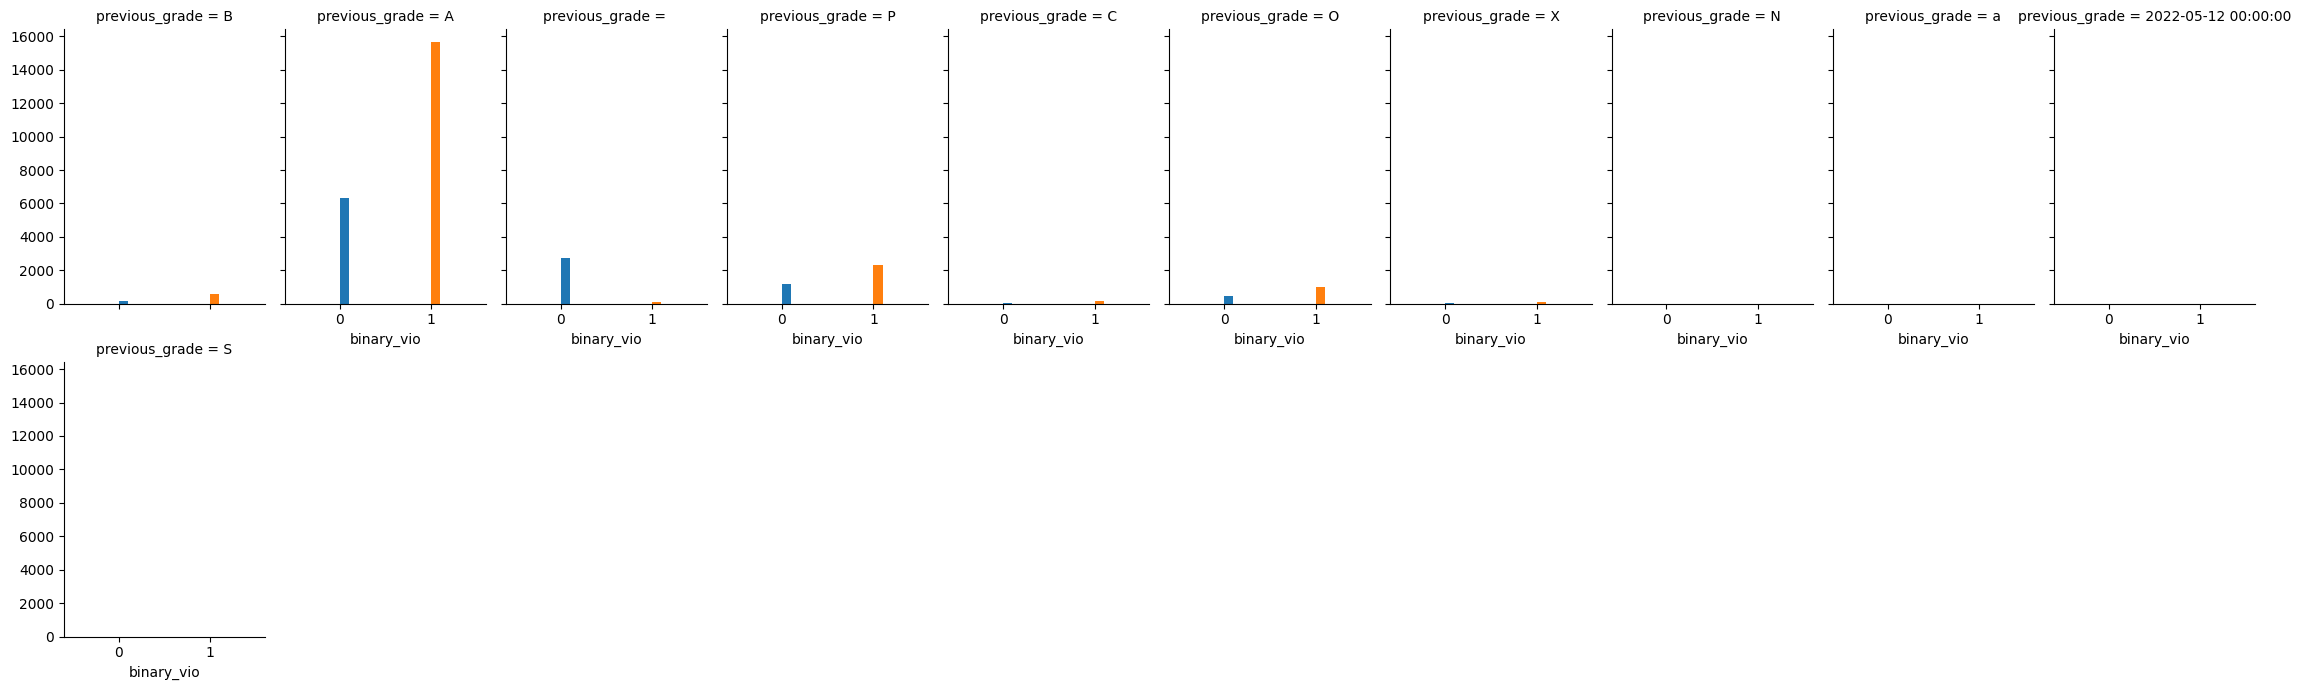

category


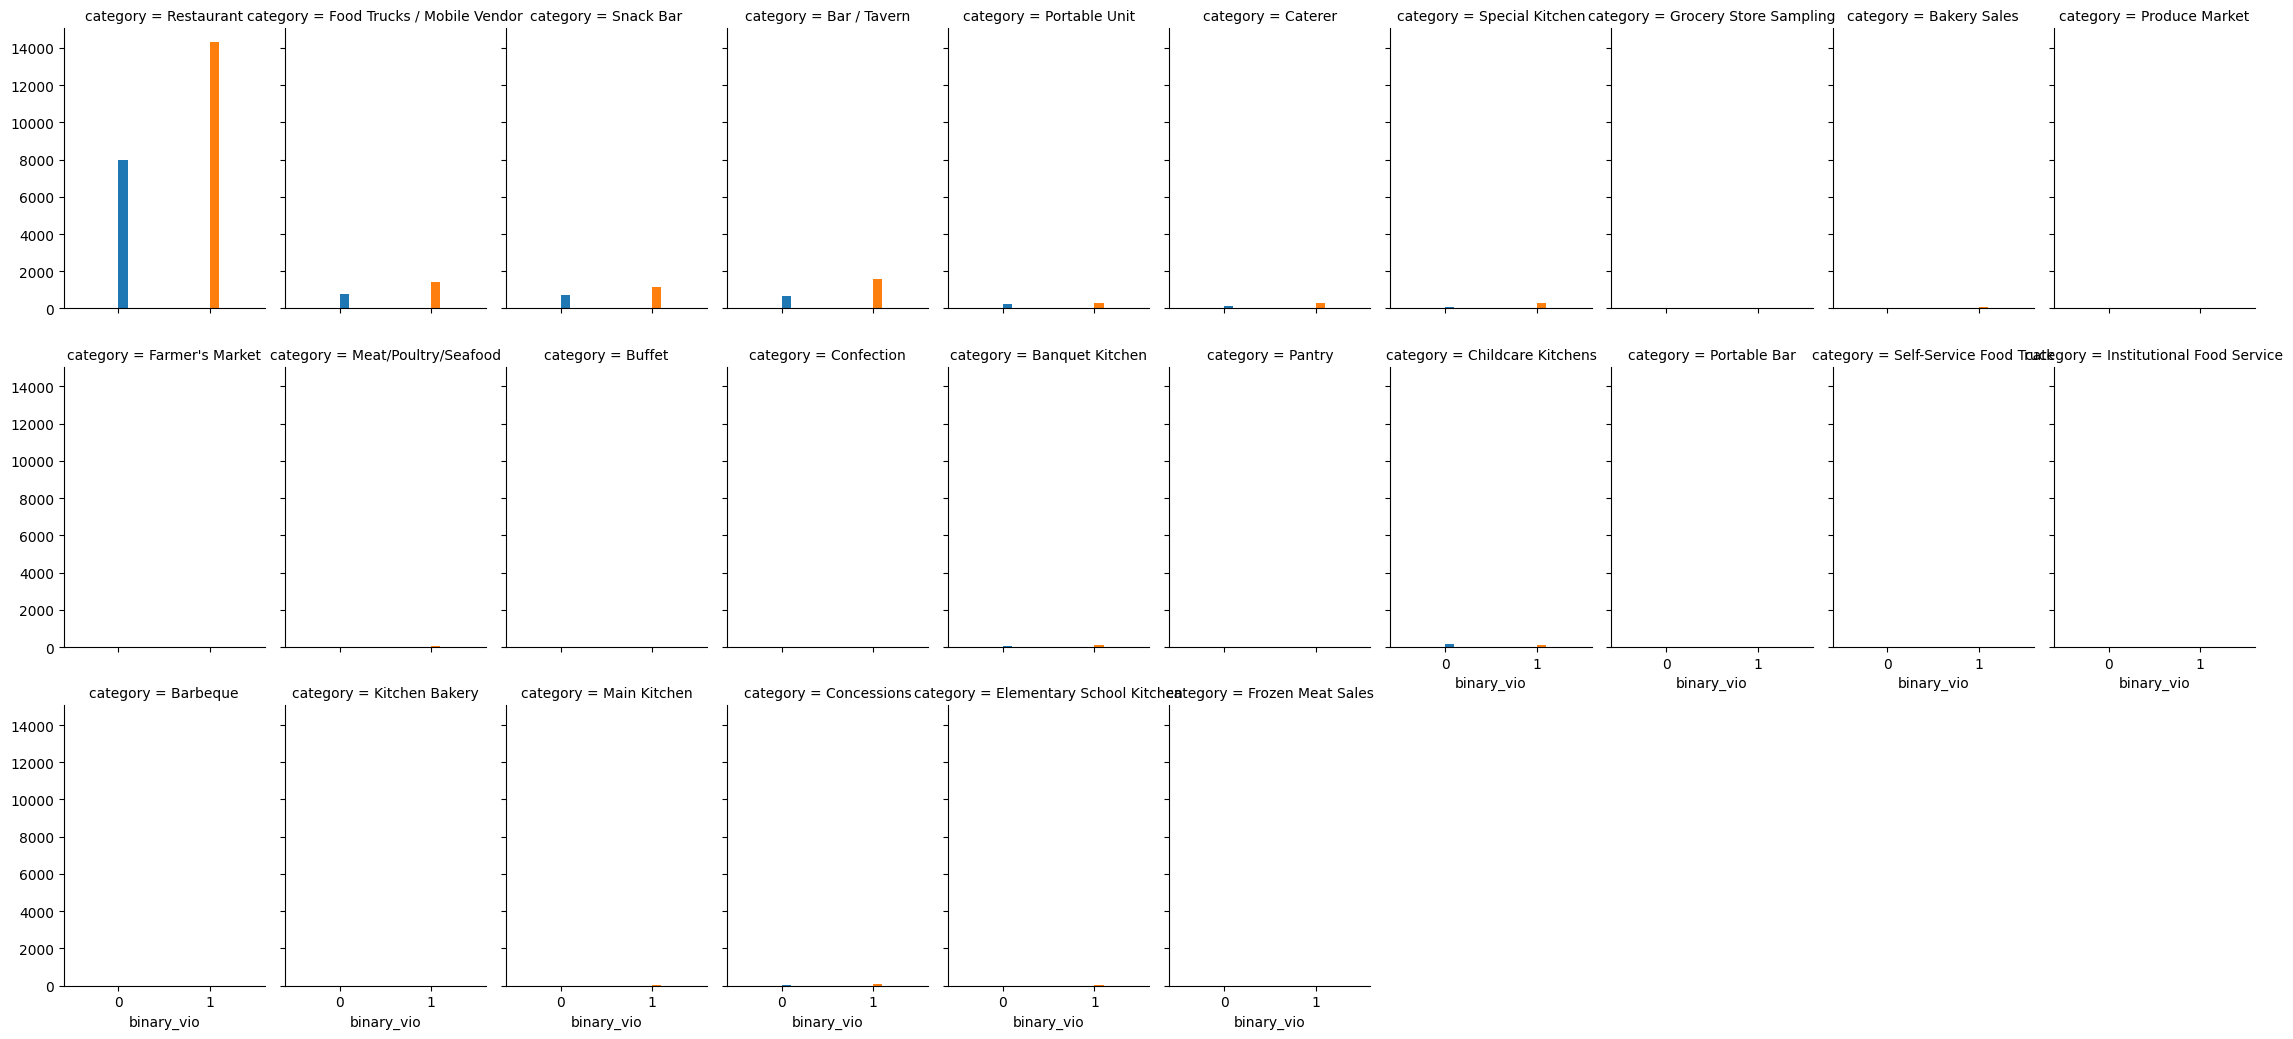

major_city


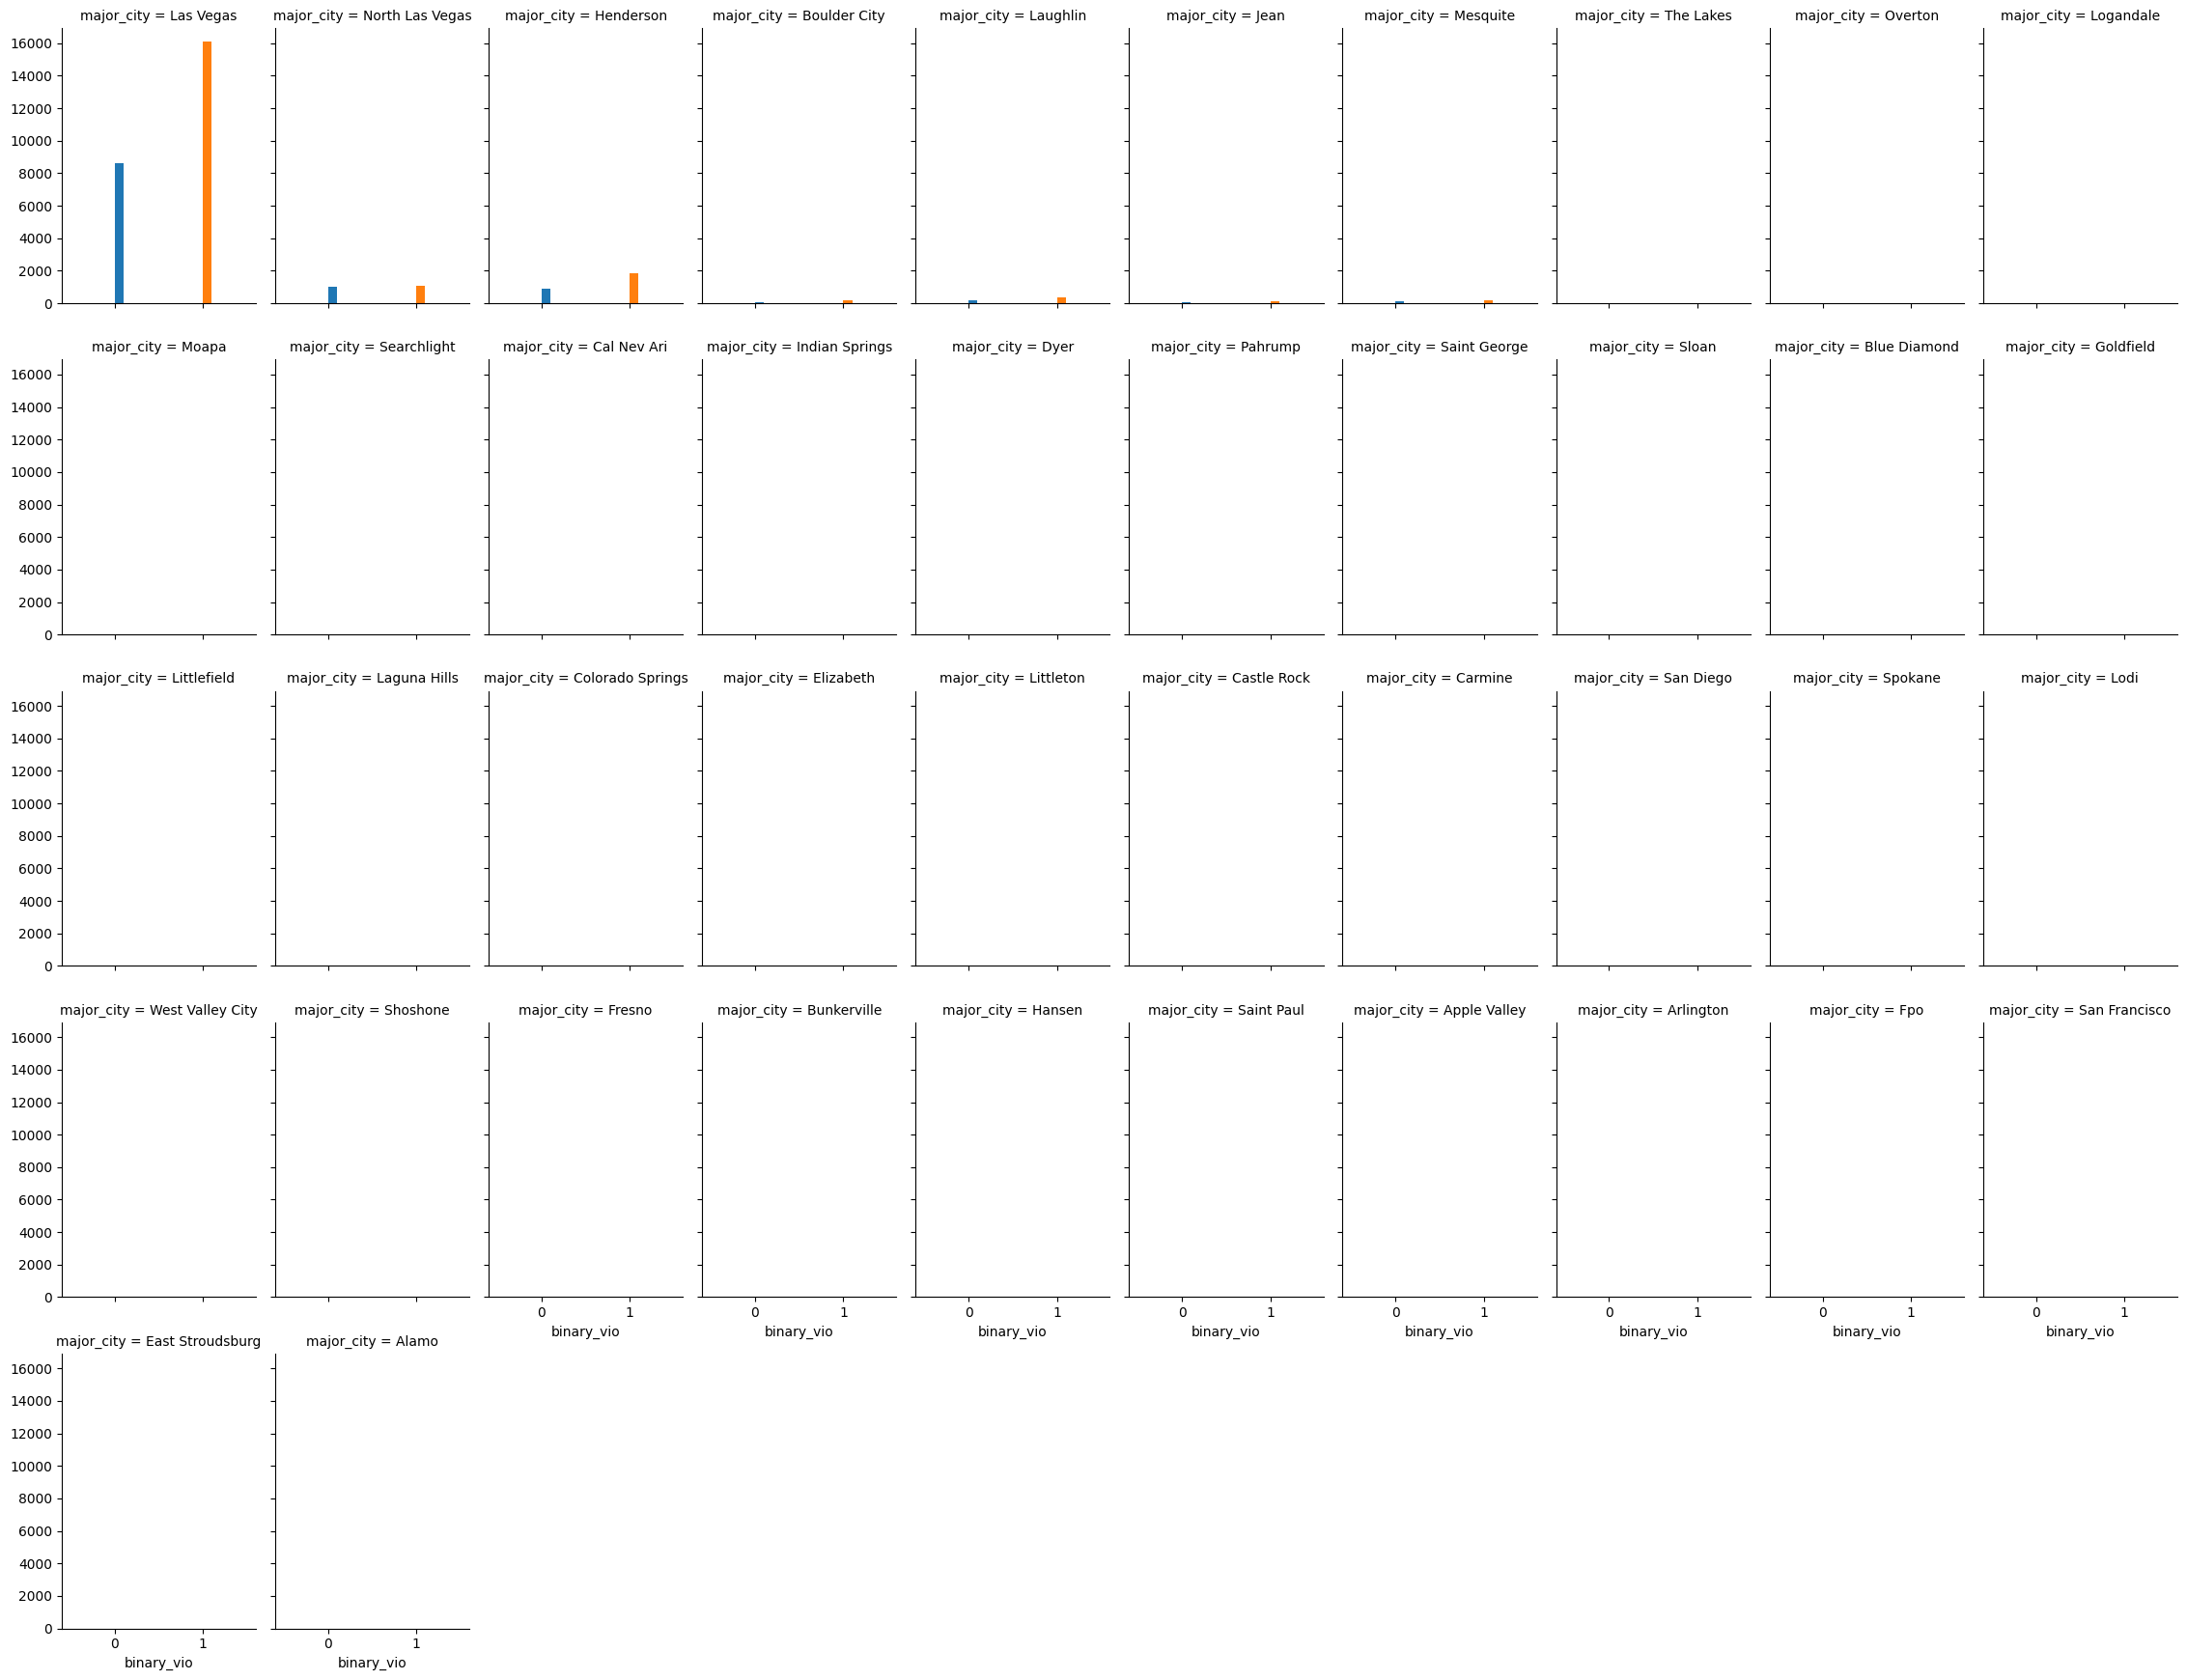

state


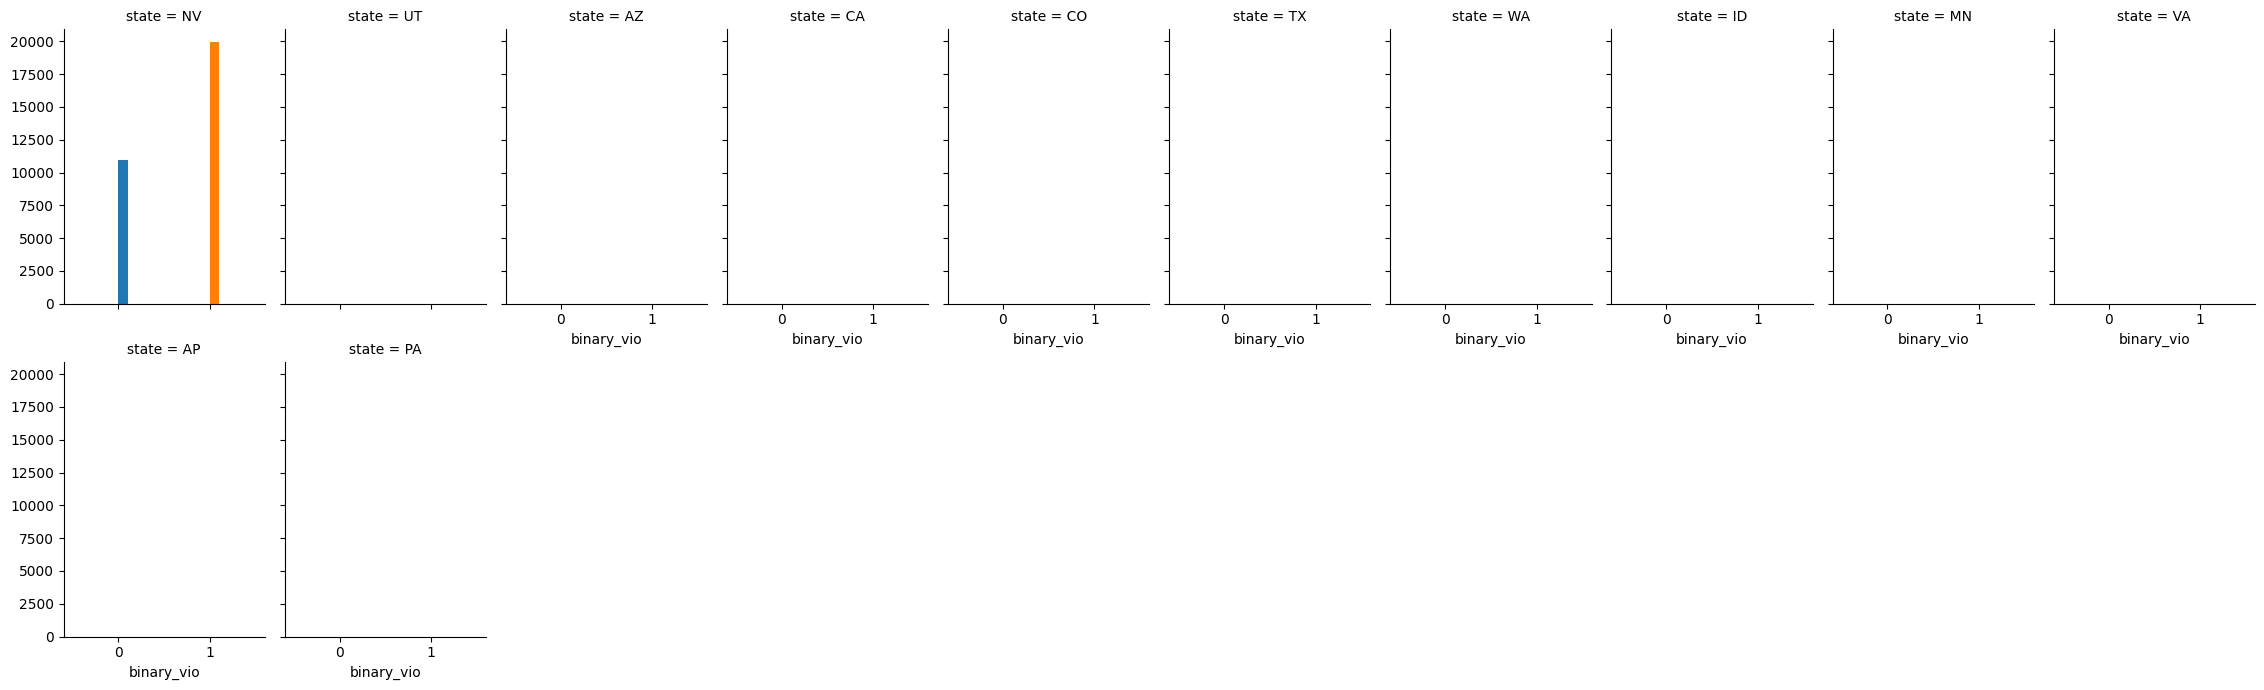

In [15]:
# Plot categorical comps
for col in categorical:
    print(col)
    g = sns.FacetGrid(df, col = col,  height=3.5, aspect=.65,col_wrap=10, hue='binary_vio')
    g.map(plt.hist, "binary_vio")
    plt.show()

###### Previous grade doesn't make too much sense to me; drop
#### Data definitely biased towards nevada, lv

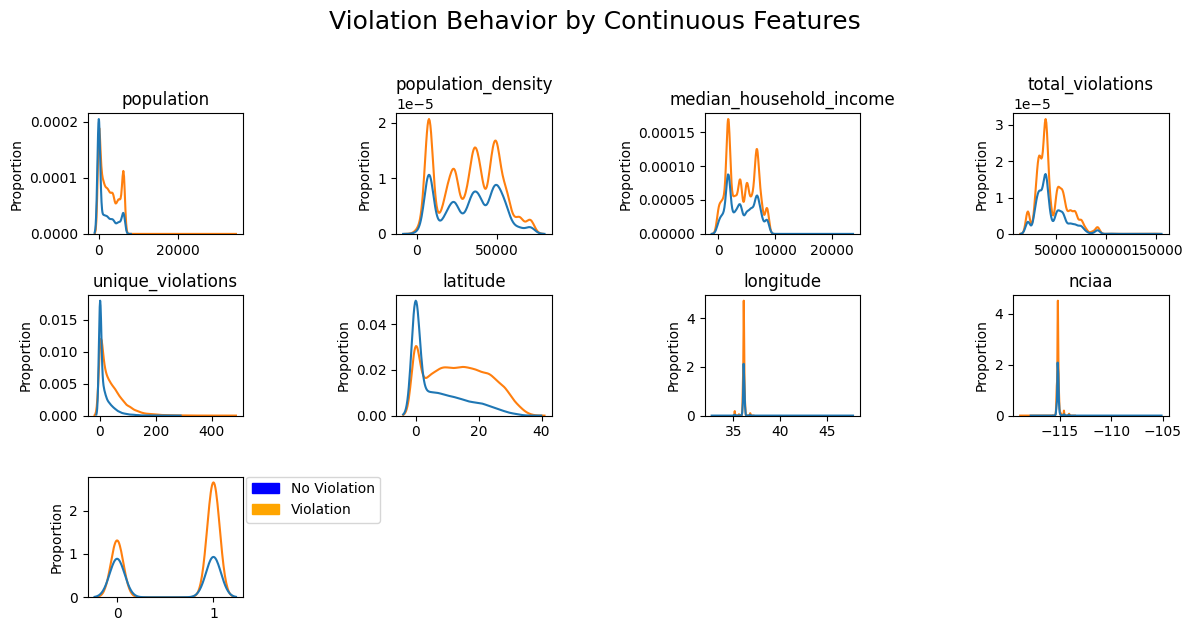

In [16]:
##### Review relationships
### Review new features' relationship with conversion
fig = plt.figure(figsize=(12,8))
for ix, ree in enumerate(contin+['nciaa']):
    plt.title(ree)
    plt.subplot(4,4,ix+1)
    sns.kdeplot(data=df, x=ree, hue="binary_vio")
    plt.legend('',frameon=False)
    plt.ylabel('Proportion')
    plt.xlabel('')
    
fig.suptitle(f'Violation Behavior by Continuous Features\n', fontsize=18)
p1 = mpatches.Patch(color='blue', label='No Violation')
p2 = mpatches.Patch(color='orange', label='Violation')
plt.legend(handles=[p1, p2],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.tight_layout()
plt.show()    

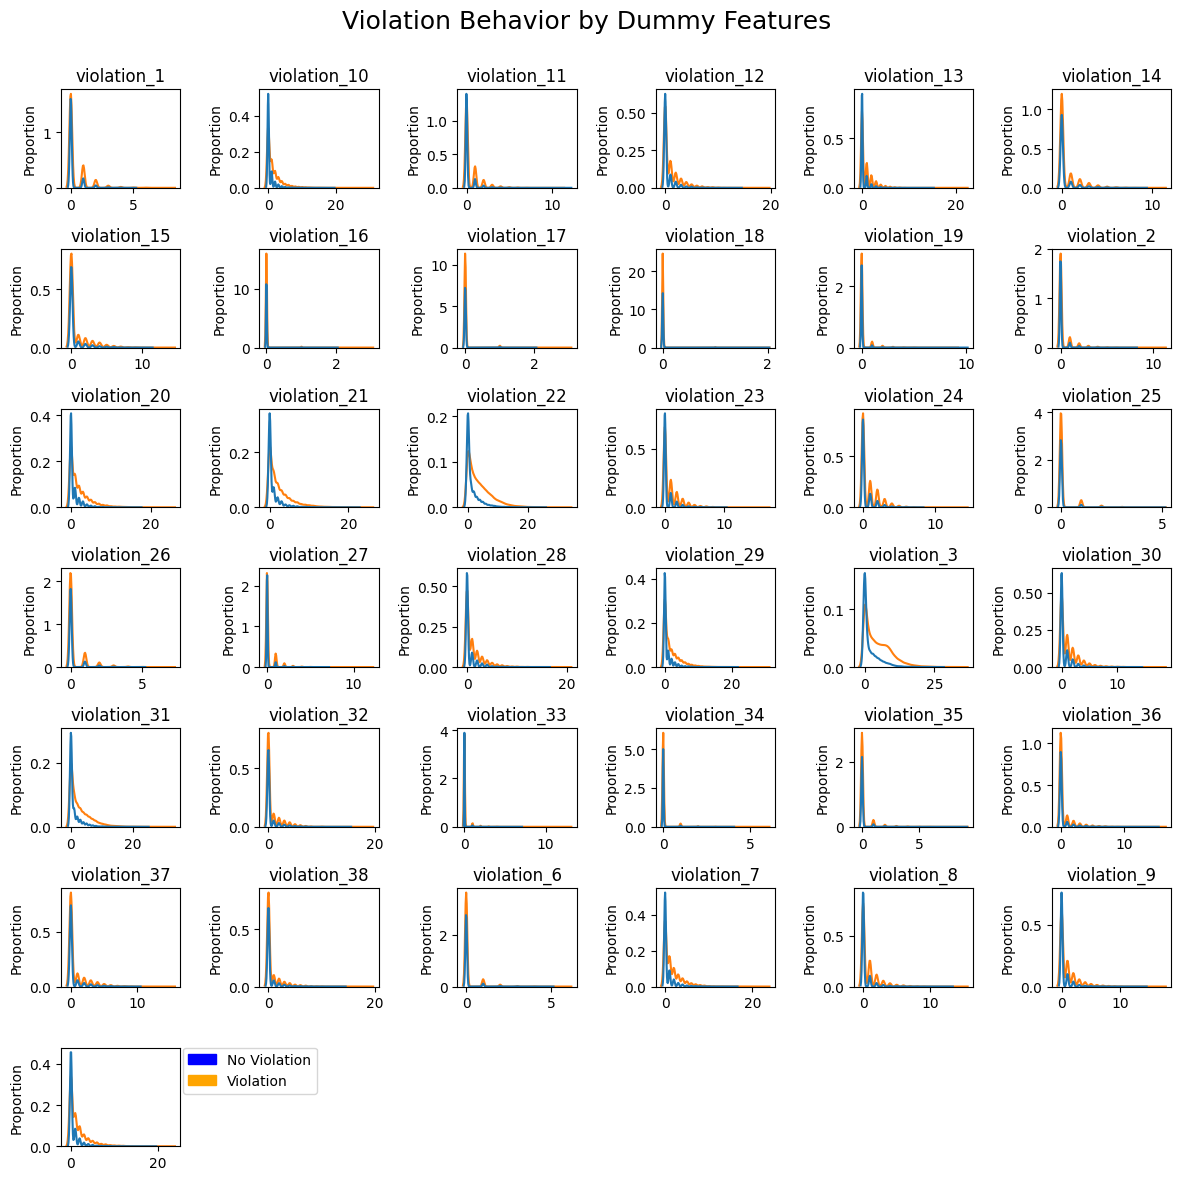

In [17]:
### Review dummys
fig = plt.figure(figsize=(12,12))
for ix, ree in enumerate(dummys):
    plt.title(ree)
    plt.subplot(7,6,ix+1)
    sns.kdeplot(data=df, x=ree, hue="binary_vio")
    plt.legend('',frameon=False)
    plt.ylabel('Proportion')
    plt.xlabel('')

fig.suptitle(f'Violation Behavior by Dummy Features\n', fontsize=18)
fig.tight_layout()
plt.legend(handles=[p1, p2],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()    

## 4. Modeling Methods<a class="anchor" id="fourth-bullet"></a>
####  Set up
- The dataset at this point contains a combination of continuous, binary, categorical, and count variables (referred to incorrectly as dummy variables)
- As this is a binary classification problem, I want to approach it with binary classification models
- For this, I’ll model the continuous, binary, and count variables with dummy categorical added basic binary classification models, and model all features out with a catboost model, as those are good with categorical variables
- Given that the goal is to identify restaurants that will have violations, I’m focused on F1
- However, the dataset is much less imbalanced than most binary classification problems, so ROC and PRAUC will be good metrics as well
- Dataset is large so there will be train, val, test
- Additionally, will stratify by the y variable and scale the dataset for less bias in large values

#### Tuning - General Binary Classification
- For the initial set of binary classification models, I chose those with the top f1 and roc and applied tuning grids in a cross validation manner
- Some of the grids were reduced from my initial set of parameters for time
- I used roc as the metric to tune to

#### Feature Importances & Re-Train
- After reviewing the feature importances for the tuned models, I dropped a few variables that had the lowest values, in addition to the dummy categorical features, and retrained the models to their ‘final’ stand point before the test round

#### CatBoost
- Trained cat boost on all variables
- Did not pursue tuning here
- Performance came out well and similar to prior binary classification models

#### NLP
- I felt that the actual violation text may have a lot to say about the condition of a restaurant
- I pursued cleaning and lemmatizing of the inspection strings (unfortunately NLTK was not working)
- I reran a catboost model containing a vectorized count of the top 150 words from the inspection strings
- The performance was in line with prior model performances
- Due to this, I decided to put NLP aside as the added information did not impact the end result

In [18]:
# Review data types
ids = ['permit_number', 'facility_id']
binary =  ['nciaa']
binary_outcome = ['binary_vio']
categorical = ['previous_grade','category', 'major_city', 'state']
string_text = ['search_text','vio_type']
contin = ['day_diff','population', 'population_density', 'median_household_income',
          'total_violations', 'unique_violations', 'latitude', 'longitude']
dummys = ['violation_0',
       'violation_1', 'violation_10', 'violation_11', 'violation_12',
       'violation_13', 'violation_14', 'violation_15', 'violation_16',
       'violation_17', 'violation_18', 'violation_19', 'violation_2',
       'violation_20', 'violation_21', 'violation_22', 'violation_23',
       'violation_24', 'violation_25', 'violation_26', 'violation_27',
       'violation_28', 'violation_29', 'violation_3', 'violation_30',
       'violation_31', 'violation_32', 'violation_33', 'violation_34',
       'violation_35', 'violation_36', 'violation_37', 'violation_38',
       'violation_6', 'violation_7', 'violation_8', 'violation_9']

In [19]:
df.binary_vio.value_counts()

1    19923
0    10949
Name: binary_vio, dtype: int64

In [20]:
####### Binary classification models
### Both tree -based and probability based

# Set X,y
X,y = df[binary+categorical+contin+dummys], df['binary_vio']
for cat_col in categorical:
    X = pd.concat([X, pd.get_dummies(X[cat_col])], axis=1)
    
X = X.drop(columns = categorical)

# Train, val, test; stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=y_train)

#Scale x values
sc = StandardScaler()
sc.fit_transform(X_train)
sc.transform(X_val)
sc.transform(X_test)

# Run through models
models = [LogisticRegression(), 
         GaussianNB(),
         RandomForestClassifier(),
         BaggingClassifier(), 
        LinearDiscriminantAnalysis(), 
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          SVC(),
         XGBClassifier(),
         LinearSVC(),
         SGDClassifier()]

outputs = []
for model in models:
    # Fit
    mod = model
    mod.fit(X_train, y_train)
    preds = mod.predict(X_val)
    # Eval
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    recall = recall_score(y_val, preds)
    prec = precision_score(y_val, preds)
    prauc = average_precision_score(y_val, preds)
    roc = roc_auc_score(y_val, preds)
    # Append
    outputs.append([model, acc, f1, recall, prec, prauc, roc])
    

# Review
model_outputs = pd.DataFrame(outputs, columns = ['model', 'accuracy', 'f1', 'recall', 'prec', 'prauc', 'roc'])

In [21]:
#### Define best performance
# Given 65-35 split, it's not fully imbalanced against 1
# What is the cost function? potentailly more important to predict 1
# Filter by f1 to start; then roc given less imbalance

model_outputs.sort_values(by='f1')

# Filter to where f1 > 0.78 & roc > 0.65

model  accuracy        f1  \
1                                        GaussianNB()  0.560162  0.536361   
6                            DecisionTreeClassifier()  0.682105  0.750540   
7                                               SVC()  0.645344  0.784449   
9                                         LinearSVC()  0.645344  0.784449   
10                                    SGDClassifier()  0.645344  0.784449   
0                                LogisticRegression()  0.663158  0.788144   
5                              KNeighborsClassifier()  0.709150  0.789053   
3   (DecisionTreeClassifier(random_state=112711168...  0.727449  0.793826   
2   (DecisionTreeClassifier(max_features='sqrt', r...  0.754656  0.826956   
8   XGBClassifier(base_score=0.5, booster='gbtree'...  0.760324  0.829336   
4                        LinearDiscriminantAnalysis()  0.748178  0.831436   

      recall      prec     prauc       roc  
1   0.394228  0.838761  0.721595  0.628164  
6   0.741029  0.760299  0.730529  0.657957  
7   1.000000  0.645344  0.645344  0.500000  
9   1.000000  0.645344  0.645344  0.500000  
10  1.000000  0.645344  0.645344  0.500000  
0   0.970891  0.663295  0.662773  0.537044  
5   0.842911  0.741665  0.726534  0.654332  
3   0.813049  0.775491  0.751160  0.692369  
2   0.908407  0.758910  0.748508  0.691646  
8   0.902384  0.767229  0.755331  0.702105  
4   0.962359  0.731870  0.728613  0.660403

In [22]:
# logreg, rf, lda, xgb
models = [LogisticRegression(), 
         RandomForestClassifier(),
        LinearDiscriminantAnalysis(), 
         XGBClassifier()]

#### Choose 1 metric to tune to
### ROC? lowest as of now and good for better balance
log_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
            'C': [0.1,1, 10, 100]}
        #    'class_weight': [{0:1, 1:1},{0:1, 1:2},{0:1, 1:3}] }

rfc_grid = {'bootstrap': [True, False],
# 'max_depth': [1, 5, 10, 20, 30, 40],
 'criterion': ['gini', 'entropy'],
# 'min_samples_leaf': [1, 3, 5, 7, 9],
 'min_samples_split': [2, 5, 10]}

lda_grid = {'solver': ['lsqr', 'eigen'],
 'n_components': [1, 2, 3, 4],
 'store_covariance': [True, False],
 'tol': [0.0001, 0.0002, 0.0003, 0.0001, 0.001, 0.01, 0.1]}

xgb_grid = {'min_child_weight': [1, 5, 10]}
 #'gamma': [0.5, 1, 1.5, 2, 5],
 #'subsample': [0.6, 0.8, 1.0],
# 'max_depth': [1, 5, 10, 20, 30, 40]}

grids = [log_grid, rfc_grid, lda_grid, xgb_grid]
grid_dct = {models[x]:grids[x] for x in range(len(models))}

output_models = []

for model, grid in grid_dct.items():
    
    ##### Roc
    # Search
    search = GridSearchCV(model, grid, scoring='roc_auc', cv=10, n_jobs=-1)
    # Fit
    results = search.fit(X_train, y_train)

    # Return
    roc_bestp = results.best_params_
    roc_bests = results.best_score_
    
    #### Output
    outzz = [model, roc_bestp, roc_bests]
    output_models.append(outzz)
    print(outzz)

[LogisticRegression(), {'C': 100, 'penalty': 'l2'}, 0.7464533029759413]
[RandomForestClassifier(), {'bootstrap': True, 'criterion': 'entropy', 'min_samples_split': 10}, 0.789761445354717]
[LinearDiscriminantAnalysis(), {'n_components': 1, 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.0001}, 0.7842416058829189]
[XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_pa

In [23]:
### Understand feature importances
to = pd.DataFrame(output_models, columns = 'model roc_params roc_score'.split(' '))

outputs = []
for ix in range(len(to)):
    # Fit
    mod = to.model[ix].set_params(**to.roc_params[ix])
    mod1 =  to.model[ix].set_params(**to.roc_params[ix])
    mod.fit(X_train, y_train)
    preds = mod.predict(X_val)
    # Eval
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    recall = recall_score(y_val, preds)
    prec = precision_score(y_val, preds)
    prauc = average_precision_score(y_val, preds)
    roc = roc_auc_score(y_val, preds)
    # Append
    outputs.append([mod1, acc, f1, recall, prec, prauc, roc])
    

# Review
model_outputs = pd.DataFrame(outputs, columns = ['model', 'accuracy', 'f1', 'recall', 'prec', 'prauc', 'roc'])

# Remove logreg for low validation performance
model_outputs = model_outputs[1:].reset_index(drop=True)
model_outputs

model  accuracy        f1  \
0  (DecisionTreeClassifier(criterion='entropy', m...  0.756599  0.830073   
1  LinearDiscriminantAnalysis(n_components=1, sol...  0.748340  0.831526   
2  XGBClassifier(base_score=0.5, booster='gbtree'...  0.756599  0.827697   

     recall      prec     prauc       roc  
0  0.921205  0.755350  0.746682  0.689141  
1  0.962359  0.732010  0.728748  0.660631  
2  0.905897  0.761925  0.750954  0.695414

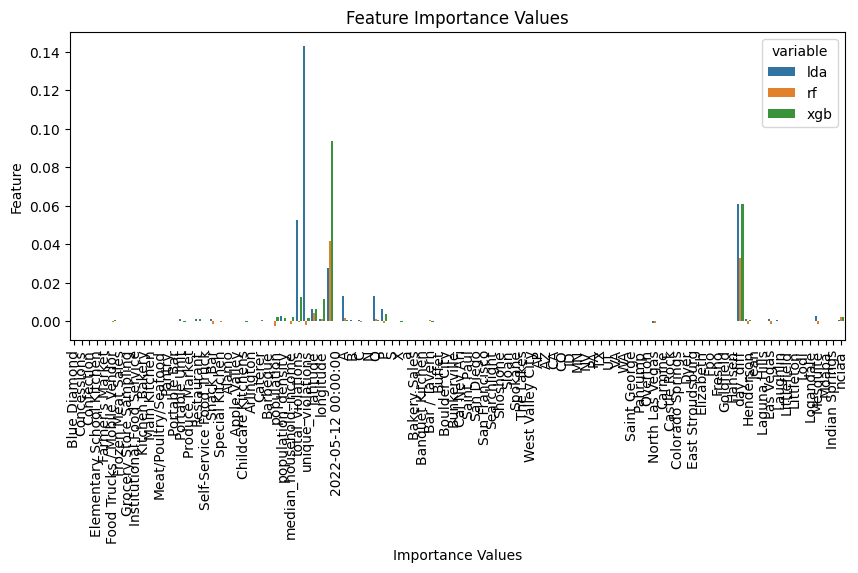

In [24]:
#### Get all feature importances
feat_imp2 = []

for mod in model_outputs.model:
    mod.fit(X_train, y_train)
    perms = permutation_importance(mod, X_val, y_val).importances_mean
    feat_imp2.append(perms)

feat_imp = pd.DataFrame(feat_imp2, columns = X_train.columns)
feat_imp = feat_imp.T.reset_index(drop=False)
feat_imp.columns = ['feature', 'rf', 'lda', 'xgb']

### Review only non dummy
fi = pd.DataFrame(feat_imp2, columns = X_train.columns)
fi = fi[[x for x in fi.columns if x not in dummys]]
fi = fi.T.reset_index(drop=False)
fi.columns = ['feature', 'rf', 'lda', 'xgb']

#### Plot feature importances
fig = plt.figure(figsize=(10,4))
sns.barplot(x='feature', y='value', 
            hue='variable', 
            data=pd.melt(fi, id_vars=['feature']).sort_values(by='variable'))
plt.xlabel('Importance Values')
plt.ylabel('Feature')
plt.title('Feature Importance Values')
plt.xticks(rotation=90)
plt.show()

In [25]:
#### Test dropping median household income, pop_density, nciaa, long, lat
### Categorical feats may not be good
### OTHER FEAT SELECT COULD BE GOOD

X,y = df[['day_diff',
 'population',
 'total_violations',
 'unique_violations']+dummys], df['binary_vio']

# Train, val, test
# Stratify 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=y_train)

outputs2 = []
for mod in model_outputs.model:
    # Fit
    mod.fit(X_train, y_train)
    preds = mod.predict(X_val)
    # Eval
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    recall = recall_score(y_val, preds)
    prec = precision_score(y_val, preds)
    prauc = average_precision_score(y_val, preds)
    roc = roc_auc_score(y_val, preds)
    # Append
    outputs2.append([mod, acc, f1, recall, prec, prauc, roc])
    

# Review
model_outputs2 = pd.DataFrame(outputs2, columns = ['model', 'accuracy', 'f1', 'recall', 'prec', 'prauc', 'roc'])
model_outputs2

model  accuracy        f1  \
0  (DecisionTreeClassifier(criterion='entropy', m...  0.726964  0.795537   
1  LinearDiscriminantAnalysis(n_components=1, sol...  0.725020  0.788543   
2  XGBClassifier(base_score=0.5, booster='gbtree'...  0.723077  0.787472   

     recall      prec     prauc       roc  
0  0.823087  0.769772  0.747759  0.687571  
1  0.794479  0.782695  0.754466  0.696555  
2  0.794981  0.780103  0.752475  0.693609

In [26]:
###### CAT BOOST
# Review data types
ids = ['permit_number', 'facility_id']
binary =  ['nciaa']
binary_outcome = ['binary_vio']
categorical = ['category', 'major_city', 'state']
string_text = ['vio_type']
contin = ['day_diff','population', 'population_density', 'median_household_income',
          'total_violations', 'unique_violations', 'latitude', 'longitude']
dummys = ['violation_0',
       'violation_1', 'violation_10', 'violation_11', 'violation_12',
       'violation_13', 'violation_14', 'violation_15', 'violation_16',
       'violation_17', 'violation_18', 'violation_19', 'violation_2',
       'violation_20', 'violation_21', 'violation_22', 'violation_23',
       'violation_24', 'violation_25', 'violation_26', 'violation_27',
       'violation_28', 'violation_29', 'violation_3', 'violation_30',
       'violation_31', 'violation_32', 'violation_33', 'violation_34',
       'violation_35', 'violation_36', 'violation_37', 'violation_38',
       'violation_6', 'violation_7', 'violation_8', 'violation_9']

0.7611975910571164
0.04128970121348303


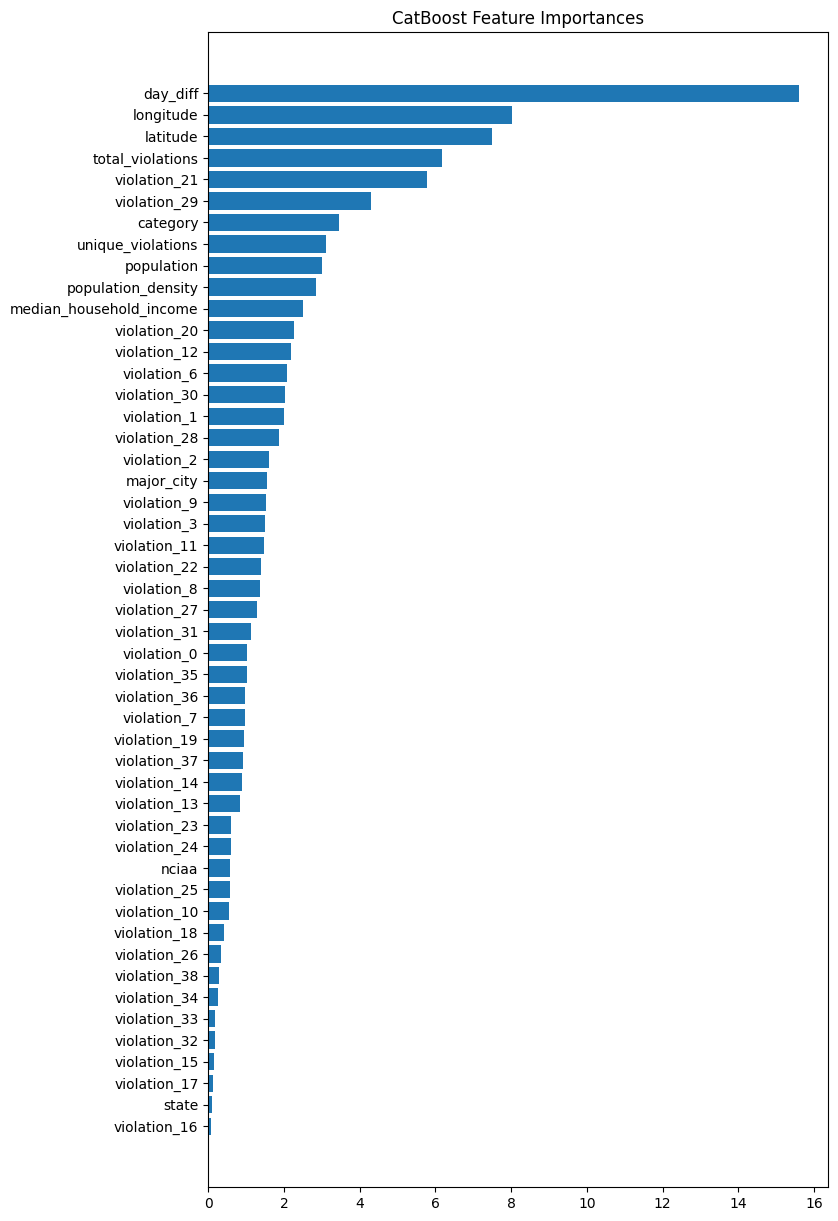

In [27]:
### Pre NLP
# Set train, test
X,y = df[binary+categorical+contin+dummys], df['binary_vio']

# Train, val, test
# Stratify 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=y_train)

cb = CatBoostClassifier(loss_function='Logloss')

pool_train = Pool(X_train, y_train,
                  cat_features = categorical)

pool_val =  Pool(X_val,
                  cat_features = categorical)

# Fit
cb.fit(pool_train, silent=True)

# Eval
preds = cb.predict(pool_val)
acc = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds)
recall = recall_score(y_val, preds)
prec = precision_score(y_val, preds)
prauc = average_precision_score(y_val, preds)
roc = roc_auc_score(y_val, preds)

# Quick review
mets = [acc, f1, recall, prec, prauc, roc]
print(np.mean(mets))
print(np.std(mets))    

# Review catboost feat importance
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('CatBoost Feature Importances')
plt.show()

In [28]:
####### NLP - clean text
### NLTK not working
# Use clean text and lemmatizer
simplefilter("ignore", category=ConvergenceWarning)
cleant = []
for ix in range(len(df)):
    tt = clean_text(df.vio_type[ix], puncts=True, stopwords=True, 
           urls=True, numbers=True, special_char=True, non_ascii=True, contractions=True)
    tt = ' '.join(text_lemmatizer(tt, lang='en'))
    cleant.append(tt)

# Append
df['clean_vio'] = cleant

0.7642241097789175
0.03992294625703826


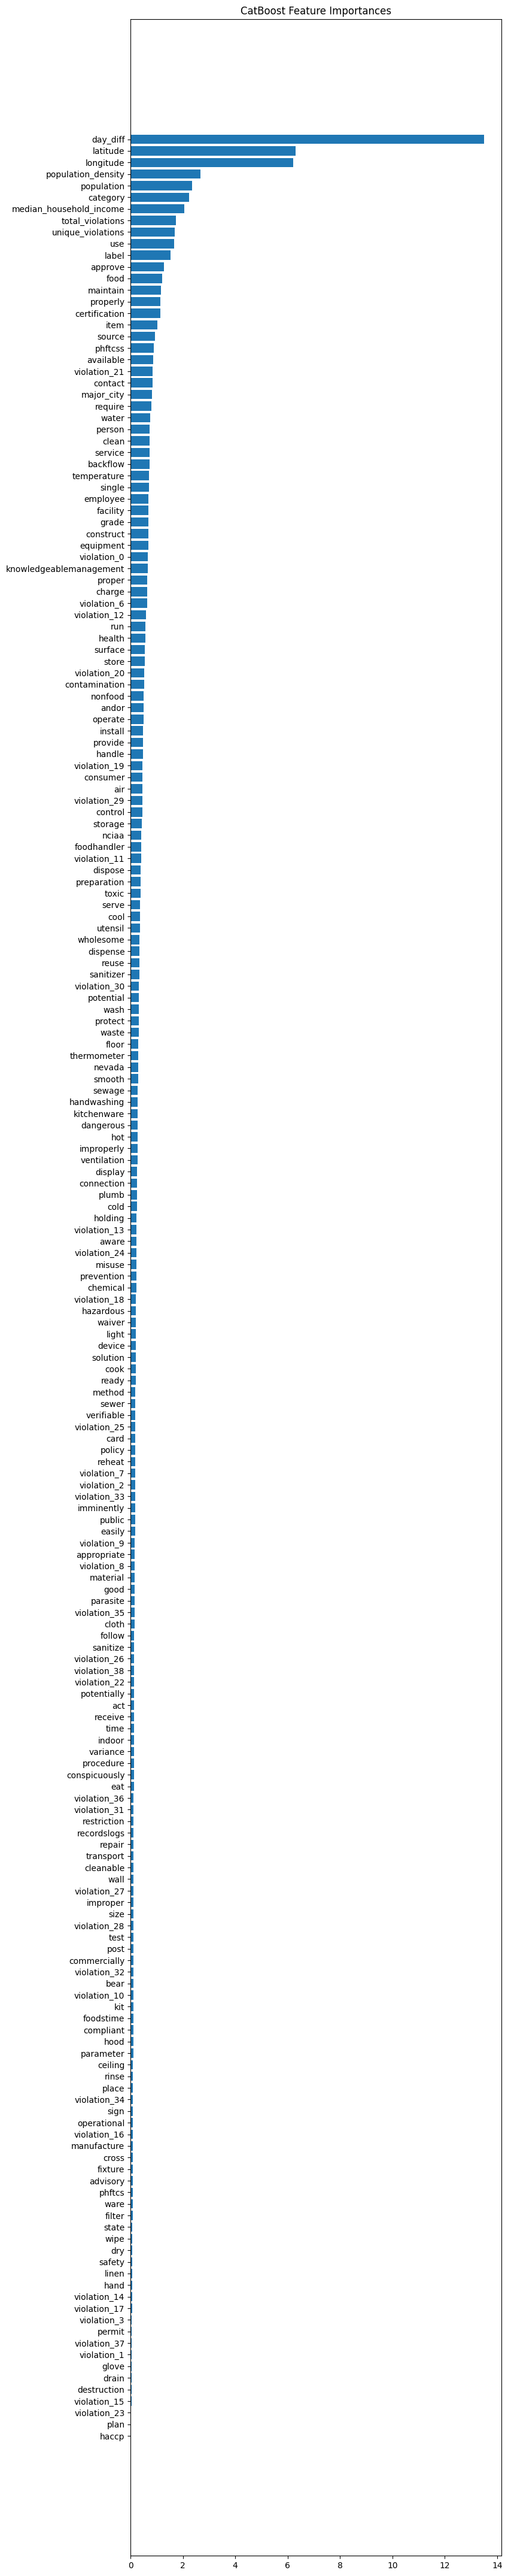

In [29]:
# Reinstitude warnings filter
simplefilter("ignore", category=ConvergenceWarning)

### Split train text
# Set train, test
X,y = df[binary+categorical+contin+dummys+['clean_vio']], df['binary_vio']

# Train, val, test
# Stratify 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=y_train)

# Get countvec; incorp max words
stop_words = text.ENGLISH_STOP_WORDS
count_vectorizer = CountVectorizer(max_features=150, stop_words = stop_words)
feature_vector = count_vectorizer.fit(X_train.clean_vio)
words = feature_vector.get_feature_names()

# Apply to datasets
output_x = []
for data in [X_train, X_val, X_test]:
    add_features = count_vectorizer.transform(data['clean_vio'])
    output_x.append(pd.concat([data.reset_index(drop=True),
          pd.DataFrame(add_features.todense(), columns=words)], axis=1))


X_train, X_val, X_test = output_x

# Reset
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train.drop(columns=['clean_vio'], inplace=True)
X_val.drop(columns=['clean_vio'], inplace=True)
X_test.drop(columns=['clean_vio'], inplace=True)

#### Run catboost to review beneficial words
# Train
cb = CatBoostClassifier(loss_function='Logloss')

pool_train = Pool(X_train, y_train,
                  cat_features = categorical)

pool_val =  Pool(X_val,
                  cat_features = categorical)

# Fit
cb.fit(pool_train, silent=True)

# Eval
preds = cb.predict(pool_val)
acc = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds)
recall = recall_score(y_val, preds)
prec = precision_score(y_val, preds)
prauc = average_precision_score(y_val, preds)
roc = roc_auc_score(y_val, preds)

# Quick review
mets = [acc, f1, recall, prec, prauc, roc]
print(np.mean(mets))
print(np.std(mets))  
    
# Review catboost feat importance
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 55))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('CatBoost Feature Importances')
plt.show()

## 5. Review Final Models<a class="anchor" id="fifth-bullet"></a>

- While the tuned basic binary classification models were at their ‘final’ stage, I needed to retrain cat boost on the selected features
- I dropped all cleaned terms, state, and nciaa 
- After comparing validation set performances, I chose cat boost
- All metrics seemed in line with each other, but cat boost contains category feature information, which was seen as important previously
- I tested the trained cat boost model on the test set and got the following metric stats:
    - Accuracy: 0.73
    - F1: 0.797
    - Recall: 0.811
    - Precision: 0.783
    - PRAUC: 0.757
    - ROC AUC: 0.701


In [30]:
####### Findings - including cleaned terms from violations does not singificantly impact performance
# Do not include moving forward

### Final round:
## Keep general bin classification
## Drop state & nciaa for catboost
# Get catboost outputs

# Set train, test
X,y = df[['category', 'major_city']+contin+dummys], df['binary_vio']

# Train, val, test
# Stratify 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=y_train)

cb = CatBoostClassifier(loss_function='Logloss')

pool_train = Pool(X_train, y_train,
                  cat_features = ['category', 'major_city'])

pool_val =  Pool(X_val,
                  cat_features = ['category', 'major_city'])

# Fit
cb.fit(pool_train, silent=True)

# Eval
preds = cb.predict(pool_val)
acc = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds)
recall = recall_score(y_val, preds)
prec = precision_score(y_val, preds)
prauc = average_precision_score(y_val, preds)
roc = roc_auc_score(y_val, preds)

# Append
cat_evals = [acc, f1, recall, prec, prauc, roc]
model_outputs2.loc[len(model_outputs2)] = [cb]+cat_evals

In [31]:
model_outputs2

model  accuracy        f1  \
0  (DecisionTreeClassifier(criterion='entropy', m...  0.726964  0.795537   
1  LinearDiscriminantAnalysis(n_components=1, sol...  0.725020  0.788543   
2  XGBClassifier(base_score=0.5, booster='gbtree'...  0.723077  0.787472   
3  <catboost.core.CatBoostClassifier object at 0x...  0.730040  0.796036   

     recall      prec     prauc       roc  
0  0.823087  0.769772  0.747759  0.687571  
1  0.794479  0.782695  0.754466  0.696555  
2  0.794981  0.780103  0.752475  0.693609  
3  0.816311  0.776743  0.752607  0.694685

In [33]:
###### Choose catboost
### Metrics all in line
## Catboost contains category which we've seen is important
### Review final
simplefilter("ignore", category=ConvergenceWarning)

# Set test
pool_test = Pool(X_test,
                  cat_features = ['category', 'major_city'])
# Eval
preds = cb.predict(pool_test)
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
recall = recall_score(y_test, preds)
prec = precision_score(y_test, preds)
prauc = average_precision_score(y_test, preds)
roc = roc_auc_score(y_test, preds)
cat_evals2 = [cb, acc, f1, recall, prec, prauc, roc]

pd.DataFrame([cat_evals2], columns = model_outputs2.columns)

model  accuracy        f1  \
0  <catboost.core.CatBoostClassifier object at 0x...  0.733441  0.797091   

     recall      prec    prauc       roc  
0  0.811292  0.783378  0.75733  0.701537

## 6. Next Steps & Further Work<a class="anchor" id="sixth-bullet"></a>
- Further tuning (removed some params for time)
- More review into interactions & polynomial features
- More detailed focus on fleshing out text columns (inspection types, restaurant names)
- Felt that I needed to either include all violation count columns or none - that may not be the case as they could be independent, and from feature importance plots its clear some are more indicative of future violations 
- Use a better method for both feature evaluation and selection
- Features like population density showed a somewhat strong difference in behavior between violation and non violation, but was dropped when modeling. Would be useful to look into this.